Tras analizar los resultados de los 2 métodos anteriores (bolsa de palabras y Word2Vec), decidimos intentar otro acercamiento: modelos *no supervisados* para la extracción de palabras clave.

Nuestras primeras pruebas consistirán simplemente en una pipeline de extracción de términos para una evaluaciómn a mano. Siendo que para cada conversación se hace un ranking de palabras (tokens), podemos elegir un número estricto (por ejemplo, 5) que represente el número máximo de palabras que nos guardamos; las k palabras con mayor puntaje. Esto lo haremos sobre TODAS las conversaciones, sin separar en conjuntos de test ni dev (puesto que no tienen etiquetas que puedan usarse para evaluar).

Existen varios métodos de extracción de palabras clave. Uno de ellos es Tf-idf, el cual ya lo usábamos en el modelo de bolsas de palabras para normalizar los datos de entrada. Otro es Textrank, que construye grafos de relaciones entre palabras, extrayendo las relaciones de acuerdo a una ventana local dada, e itera con una determinada función de puntaje para cada palabra. Probaremos al menos estos 2 métodos. 

In [6]:
from filterTools import csvFilter
from dataTools import build_chats, total_chats, filter_chats, filter_classes
import json

##### Hiperparámetros #####
allow_students = False
allow_approved = False

order_by_ex = True
assign_ids = True

max_length = 20000
min_length = 250
min_ex = 10
###########################

## Leemos las tablas que tenemos
discs = csvFilter('db/discussions.csv')
msgs = csvFilter('db/messages.csv')

## Opcionalmente vemos los ids de los tutores (para restringir a mensajes aprovados)
tutors = [int(id) for id in csvFilter('db/messages.csv', lambda msg: msg['from_moderator'] == 'True', saveField='sender_uid')]

## Creamos las conversaciones y las organizamos en un diccionario
## En este ya estan clasificadas, esta vez por id de conversacion
all_chats = build_chats(discs, msgs, use_ids=assign_ids, use_exs=order_by_ex, approved_msgs=allow_approved, students_msgs=allow_students, approved_ids=tutors)
print(f'Conversaciones totales: {total_chats(all_chats)}')


# Etapa de filtros

## Funcion que filtra las conversaciones (pueden agregarse mas cosas aqui)
def chat_filter(chat):
    return len(chat) <= max_length and len(chat) >= min_length

## Funcion que filtra las clases (pueden agregarse mas cosas aqui)
def ex_filter(chats):
    return len(chats) >= min_ex

## Filtramos por chat
filtered_chats = filter_chats(all_chats, chat_filter)
print(f'\nConversaciones tras filtros individuales: {total_chats(filtered_chats)}')
all_chats.clear()

## Filtramos por ej. (si aplica)
if order_by_ex:
    filtered_chats = filter_classes(filtered_chats, ex_filter)
    print(f'\nConversaciones tras filtros de clase: {total_chats(filtered_chats)}')

# Convertimos a json y guardamos
with open('data/all_chats-tutors-divided.json', 'w', encoding='utf-8') as f1:
    json.dump(filtered_chats, f1)
    print('\nConversaciones guardadas!')
    filtered_chats.clear()

Conversaciones totales: 12103

Conversaciones tras filtros individuales: 10673

Conversaciones tras filtros de clase: 10528

Conversaciones guardadas!


In [4]:
import json
from dataTools import separate_classes, clean_text
import spacy as sp
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from numpy import array
import re

##### Hiperparámetros #####
lowercase = True
remove_spaces = True
remove_punctuation = False
translate_emojis = True
rem_rep_chars = True

char_limit = 12
stop_symbols = ["...", " ", '*', '"', "'", ',', ';', '.', '`', '~', '!', '?', '¡', '¿', '$', '@', '&', '(', ')', '-', '=', '_', '^', '&&', ':', '/', '\\', '[', ']', '{', '}', '+', '||', '>', '<', '>=', '<=', '=<', '=>', '->', '<-']

top_k = 5
###########################
symbols_combos = [w1 + w2 for w1 in stop_symbols for w2 in stop_symbols + ["", " "]]

# Recuperación de los datos guardados
with open('data/all_chats-approved.json', 'r', encoding='utf-8') as f1:
    all_chats = json.load(f1)
    print('Conversaciones cargadas')

## Separamos en textos e ids de conversaciones
all_chats = separate_classes(all_chats)

## Función para procesar cada conversación con Spacy.
nlp = sp.load('es_core_news_sm')
def tokenizer(text):
    tokens = nlp(text)
    return [token.lemma_ for token in tokens if len(token.text) <= char_limit and token.text not in symbols_combos]

## Función de filtrado de código en markdown
def filter_md(msg):
  return re.sub(r'```.*```', '', msg, flags=re.DOTALL)

## Funcion de preprocesamiento.
def preprocess(text):
    return clean_text(filter_md(text), lowercase=lowercase, remove_spaces=remove_spaces, remove_punctuation=remove_punctuation, translate_emojis=translate_emojis, rem_rep_chars=rem_rep_chars)

## Pipeline de SKlearn
text_clf = Pipeline([
    ('vect', CountVectorizer(preprocessor=preprocess, tokenizer=tokenizer)),
    ('tfidf', TfidfTransformer(use_idf=True)),
], verbose=True)

text_clf.fit(all_chats[0], all_chats[1])
words = array(text_clf.get_feature_names_out())
counts = text_clf.transform(all_chats[0]).toarray()

with open('data/KeywordExtract/Tf-idf/approved/keywords-lemma-approved.txt', 'w', encoding='utf-8') as f:
    for j in range(counts.shape[0]):
        f.write(f'Keywords_{all_chats[1][j]}: {", ".join(words[counts[j, :].argsort()[-top_k:][::-1]])}\n')
    print('\nPalabras clave guardadas!')

Conversaciones cargadas


c:\Users\fran_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] .............. (step 1 of 2) Processing vect, total= 8.2min
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s

Palabras clave guardadas!


Nuevas tareas:
* Ordenar y calcular keywords por ejercicio (usando idf a partir de cada grupo). Quitar la limitación superior por caracteres (con 20.000 anda) y agregar un parámetro para limitar por número mínimo de conversaciones en ej. (por el momento 1).
* Visualización: mostrar en el archivo final el ejercicio de cada conversación. Usar un score para cada ejercicio (en numero de conversaciones que tiene). Hacer un ranking final: cantidad de repeticiones de cada keyword, y en cuántas conversaciones y en cuántos ej. aparece.
* Repetir el análisis guardando solamente mensajes de tutores.
* Usar stop words nuevas en un archivo aparte. Mover el filtro de stop words al final del proceso (cuando se obtiene el ranking de keywords). 

Para las nuevas tareas, trabajamos sobre el mismo bloque de código para recopilación y filtrado de datos. Para la extracción en sí, empezamos por aparte:

In [10]:
import json
from dataTools import separate_classes, clean_text
import spacy as sp
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from numpy import array
import re

##### Hiperparámetros #####
lowercase = True
remove_spaces = True
remove_punctuation = False
translate_emojis = True
rem_rep_chars = True

char_top_limit = 12
chat_bottom_limit = 2
stop_symbols = ["...", " ", '*', '"', "'", ',', ';', '.', '`', '~', '!', '?', '¡', '¿', '$', '@', '&', '(', ')', '-', '=', '_', '^', '&&', ':', '/', '\\', '[', ']', '{', '}', '+', '||', '>', '<', '>=', '<=', '=<', '=>', '->', '<-', '#']

top_k = 5
###########################

# Recuperación de los datos guardados
with open('data/all_chats-tutors-divided.json', 'r', encoding='utf-8') as f1:
    all_chats = json.load(f1)
    print('Conversaciones cargadas')

## Separamos en textos e ids de conversación
all_chats = {ex: separate_classes(ex_chats) for ex, ex_chats in all_chats.items()}

## Función para procesar cada conversación con Spacy.
nlp = sp.load('es_core_news_sm')
def tokenizer(text):
    tokens = nlp(text)
    return [token.lemma_ for token in tokens]

## Función de filtrado de código en markdown
def filter_md(msg):
  return re.sub(r'```.*```', '', msg, flags=re.DOTALL)

## Funcion de preprocesamiento.
def preprocess(text):
    return clean_text(filter_md(text), lowercase=lowercase, remove_spaces=remove_spaces, remove_punctuation=remove_punctuation, translate_emojis=translate_emojis, rem_rep_chars=rem_rep_chars)

print('\nExtrayendo...')
## Pipeline de SKlearn (por ej.)
pipelines = {}
for ex, ex_chats in all_chats.items():
    text_clf = Pipeline([
        ('vect', CountVectorizer(preprocessor=preprocess, tokenizer=tokenizer)),
        ('tfidf', TfidfTransformer(use_idf=True)),
    ], verbose=False)
    text_clf.fit(ex_chats[0], ex_chats[1])
    pipelines[ex] = text_clf

print('\nRankeando...')
## Ranking
stop_words = []
with open('db/spanish-stopwords-large.txt', 'r', encoding='utf-8') as f2:
    for line in f2:
        stop_words.append(line.strip())

## Función de filtro de tokens
def token_approve(token):
    return len(token) <= char_top_limit and len(token) >= chat_bottom_limit and not any([symbol in token for symbol in stop_symbols]) and token not in stop_words and re.search('\d+', token) is None

## Exportamos ranking en ambos txt (legible) y json (reutilizable)
with open('data/KeywordExtract/Tf-idf/tutors/keywords-tutors-divided.txt', 'w', encoding='utf-8') as fw1:
    all_kws = {}
    for ex, text_clf in pipelines.items():
        words = array(text_clf.get_feature_names_out())
        counts = text_clf.transform(all_chats[ex][0]).toarray()
        
        all_kws[ex] = {}
        fw1.write(f'<ex__{ex} -- Conversaciones totales: {counts.shape[0]}\n')
        for j in range(counts.shape[0]):
            keywords = words[[idx for idx in counts[j, :].argsort() if token_approve(words[idx])][-top_k:][::-1]]
            all_kws[ex][all_chats[ex][1][j]] = list(keywords)
            fw1.write(f'--keywords__{all_chats[ex][1][j]}: {" ".join(keywords)}\n')
        fw1.write('>-------------------\n\n')
    print('\nPalabras clave escritas en txt')

    with open('data/KeywordExtract/Tf-idf/tutors/keywords-tutors-divided.json', 'w', encoding='utf-8') as fw2:
        json.dump(all_kws, fw2)
        print('\nPalabras clave exportadas en json')

## Guardamos además la lista de símbolos que eliminamos
with open('db/stop-symbols.txt', 'w', encoding='utf-8') as fw3:
    for s in stop_symbols:
        fw3.write(f'{s}\n')
    print('\nStop Symbols guardados!')

Conversaciones cargadas

Extrayendo...

Rankeando...

Palabras clave escritas en txt

Palabras clave exportadas en json

Stop Symbols guardados!


A continuación, el ranking global de palabras clave sobre cada ejercicio (conjunto de conversaciones).

In [13]:
import json
from dataTools import vocab_from_lists
import csv

countGlobal = False

## Recuperamos las keywords
with open('data/KeywordExtract/TopicRank/tutors/keywords-tutors-divided.json', 'r', encoding='utf-8') as f1:
    all_kws = json.load(f1)
    print('Keywords cargadas')
                
kws_vocab = vocab_from_lists(all_kws, countLocal=True, countGlobal=countGlobal)
with open('data/KeywordExtract/TopicRank/tutors/kws-tutors-ranking-divided.json', 'w', encoding='utf-8') as fw1:
    json.dump(kws_vocab, fw1)
    print('\nVocabulario construido y guardado')

with open('data/KeywordExtract/TopicRank/tutors/kws-tutors-ranking-divided.txt', 'w', encoding='utf-8') as fw2:
    if countGlobal:
        for word, info in sorted(kws_vocab.items(), key=lambda item: item[1]['count'], reverse=True):
            fw2.write(f"<Keyword: '{word}' -- En ejercicios: {info['count']}\n")
            for ex, chats in sorted(info['exs'].items(), key=lambda item: item[1]['count'], reverse=True):
                fw2.write(f"--Ejercicio {ex}, en conversaciones: (total: {chats['count']}) - {', '.join(chats['chats'])}\n")
            fw2.write('>-------------------\n\n')
    else:
        for ex, info in sorted(kws_vocab.items(), key=lambda item: item[1]['count'], reverse=True):
            fw2.write(f"<Ejercicio: {ex} -- Vocabulario: {info['count']}\n")
            for word, chats in sorted(info['words'].items(), key=lambda item: item[1]['count'], reverse=True):
                fw2.write(f"--Keyword: '{word}', en conversaciones: (total: {chats['count']}) - {', '.join(chats['chats'])}\n")
            fw2.write('>-------------------\n\n')
    print('\nVocabulario exportado a txt')

chatRows = []
for ex, chats in all_kws.items():
    for chat, kws in chats.items():
        chatRows.append({
            'ejercicio_id': ex,
            'conversación_id': chat,
            'kw1': '' if len(kws) < 1 else kws[0],
            'kw2': '' if len(kws) < 2 else kws[1],
            'kw3': '' if len(kws) < 3 else kws[2],
            'kw4': '' if len(kws) < 4 else kws[3],
            'kw5': '' if len(kws) < 5 else kws[4]
        })
with open('data/KeywordExtract/TopicRank/tutors/keywords-tutors-divided.csv', 'w', newline='', encoding='utf-8') as fw3:
    table_write = csv.DictWriter(fw3, fieldnames=chatRows[0].keys())
    table_write.writeheader()
    table_write.writerows(chatRows)
    print('\nPalabras clave exportadas a csv')

if countGlobal:
    kwsRows = []
    for word, info in sorted(kws_vocab.items(), key=lambda item: item[1]['count'], reverse=True):
        wordChats = []
        for ex, chats in info['exs'].items():
            wordChats = wordChats + chats['chats']
        kwsRows.append({'keyword': word, 'ocurrencias totales': len(wordChats), 'ejercicios totales': info['count'], 'IDs de conversaciones': ", ".join(wordChats), 'IDs de ejercicios': ", ".join(info['exs'].keys())})
    with open('data/KeywordExtract/TopicRank/tutors/kws-tutors-ranking.csv', 'w', newline='', encoding='utf-8') as fw4:
        table_write = csv.DictWriter(fw4, fieldnames=kwsRows[0].keys())
        table_write.writeheader()
        table_write.writerows(kwsRows)
        print('\nVocabulario exportado a csv')

Keywords cargadas

Vocabulario construido y guardado

Vocabulario exportado a txt

Palabras clave exportadas a csv


A continuación, probamos los resultados con TextRank. Instalación:

```
pip install summa
```

Summa implementa el algoritmo de TextRank con 1 sola función, aplicada esta vez sobre cada conversación independiente, sin mirar el contexto global. Esto quiere decir que volvemos a tomar *todas* las conversaciones a la vez, sin separar por ejercicio. Aplicamos los mismos filtros generales (en principio, sólo mensajes de tutores) y la misma normalización posterior.

Una alternativa a considerar (posiblemente mejor), es pytextrank, integrado a Spacy:

```
pip install pytextrank
```

In [ ]:
import json
from dataTools import clean_text, total_chats
import re
from summa import keywords
import spacy as sp
import pytextrank
from spacy.tokens import Span

##### Hiperparámetros #####
lowercase = True
remove_spaces = True
remove_punctuation = False
translate_emojis = True
rem_rep_chars = True

char_top_limit = 12
chat_bottom_limit = 2
stop_symbols = [".", '*', '"', "'", ',', ';', '.', '`', '~', '!', '?', '¡', '¿', '$', '@', '&', '(', ')', '-', '=', '_', '^', '&&', ':', '/', '\\', '[', ']', '{', '}', '+', '||', '>', '<', '>=', '<=', '=<', '=>', '->', '<-', '#']

top_k = 5

use_topicrank = False
stop_spans = ["un", "una", "unos", "unas", "el", "la", "lo", "los", "las", "le", "les", "tu", "tus", "su", "sus", "mi", "mis", "nuestro", "nuestros", "nuestra", "nuestras", "esto", "este", "esta", "estos", "estas", "eso", "ese", "esa", "esos", "esas"]
edge_weight = 1.0
window_size = 3
tags_keep = ["ADJ", "NOUN"]
###########################

# Recuperación de los datos guardados
with open('data/all_chats-tutors-divided.json', 'r', encoding='utf-8') as f1:
    all_chats = json.load(f1)
    print('Conversaciones cargadas')

## Función de filtrado de código en markdown
def filter_md(msg):
  return re.sub(r'```.*```', '', msg, flags=re.DOTALL)

## Funcion de preprocesamiento.
def preprocess(text):
    return clean_text(filter_md(text), lowercase=lowercase, remove_spaces=remove_spaces, remove_punctuation=remove_punctuation, remove_emojis=not translate_emojis, rem_rep_chars=rem_rep_chars)

## Ranking
stop_words = []
with open('db/spanish-stopwords-large.txt', 'r', encoding='utf-8') as f2:
    for line in f2:
        stop_words.append(line.strip())

## Función de filtro de tokens
def token_approve(token):
    return len(token) <= char_top_limit and len(token) >= chat_bottom_limit and not any([symbol in token for symbol in stop_symbols]) and token not in stop_words and re.search('\d+', token) is None

## Función de limpieza de token (scrubbing)
@sp.registry.misc("prefix_scrubber")
def prefix_scrubber():
    def scrubber_func(span: Span) -> str:
        while span[0].text in stop_spans and len(span) > 1:
            span = span[1:]
        return span.text
    return scrubber_func

nlp = sp.load('es_core_news_sm')
if use_topicrank:
    nlp.add_pipe("topicrank", config={"edge_weight": edge_weight, "token_lookback": window_size, "pos_kept": tags_keep, "scrubber": {"@misc": "prefix_scrubber"}})
else:
    nlp.add_pipe("textrank", config={"edge_weight": edge_weight, "token_lookback": window_size, "pos_kept": tags_keep, "scrubber": {"@misc": "prefix_scrubber"}})

with open('data/KeywordExtract/TextRank/tutors/keywords-tutors-divided.txt', 'w', encoding='utf-8') as fw1:
    all_kws = {}
    for ex, ex_chats in all_chats.items():
        all_kws[ex] = {}
        fw1.write(f'<ex__{ex} -- Conversaciones totales: {total_chats(ex_chats)}\n')
        for id_chat, chat in ex_chats.items():
            # kws = [kw for kw in keywords.keywords(preprocess(chat)).split("\n") if token_approve(kw)]
            doc = nlp(preprocess(chat))
            kws = [kw.text for kw in doc._.phrases if token_approve(kw.text)][:top_k]
            fw1.write(f'--keywords__{id_chat}: {", ".join(kws)}\n')
            all_kws[ex][id_chat] = kws
    print('\nPalabras clave escritas en txt')

    with open('data/KeywordExtract/TextRank/tutors/keywords-tutors-divided.json', 'w', encoding='utf-8') as fw2:
        json.dump(all_kws, fw2)
        print('\nPalabras clave exportadas en json')

## Guardamos además la lista de símbolos que eliminamos
with open('db/stop-symbols.txt', 'w', encoding='utf-8') as fw3:
    for w in stop_symbols:
        fw3.write(f'{w}\n')
    print('\nStop Symbols guardados!')

with open('db/stop-spans.txt', 'w', encoding='utf-8') as fw4:
    for s in stop_spans:
        fw4.write(f'{s}\n')
    print('\nStop spans guardados!')

Considerar:

* Los mensajes de tutores al principio de la conversación son los más importantes.
* Mensajes que citan el reglamento se descartan.
* Los mensajes con links a otras conversaciones se descartan.
* Oraciones importantes suceden más al principio de los mensajes (y no en enumeraciones)
* Hay que ignorar saludos, nombres propios, etc.
* Nueva planilla de palabras clave: agregar conversación completa, largo de la misma, 2 primeras oraciones del resumen extractivo.
* Guardar el ID de cada mensaje.

En primer lugar, hacemos una modificación a la función que recopila las conversaciones para guardar información extra: los ID de los mensajes y la posición de cada uno. En consecuencia, agregamos un nuevo nivel a la jerarquía, dejándonos con *ejercicios -> conversaciones -> mensajes -> palabras*

Resumimos todo el código completo en un solo bloque:

In [6]:
from filterTools import csvFilter
from dataTools import build_chats, clean_text
import json
from functools import reduce
import re
import spacy as sp
import pytextrank
from spacy.tokens import Span

##### Hiperparámetros #####
lowercase = False
remove_spaces = False
remove_punctuation = False
remove_emojis = True
rem_rep_chars = True
reject_fragments = ['[URL]']
remove_code = ['</>', '_', '<p>', '</p>']
remove_code_with_space = ['<br>', '</br>', '<br/>', '<br />']

char_top_limit = 12
chat_bottom_limit = 2
stop_symbols = ["\n", ".", '*', '"', "'", ',', ';', '.', '`', '~', '!', '?', '¡', '¿', '$', '@', '&', '(', ')', '-', '=', '_', '^', '&&', ':', '/', '\\', '[', ']', '{', '}', '+', '||', '>', '<', '>=', '<=', '=<', '=>', '->', '<-', '#']

top_k = 5

use_topicrank = False
stop_spans = ["un", "una", "unos", "unas", "el", "la", "lo", "los", "las", "le", "les", "tu", "tus", "su", "sus", "mi", "mis", "nuestro", "nuestros", "nuestra", "nuestras", "esto", "este", "esta", "estos", "estas", "eso", "ese", "esa", "esos", "esas"]
edge_weight = 1.0
window_size = 3
tags_keep = ["ADJ", "NOUN"]

sent_number = 8
max_phrases = 10
preserve_order = False
sent_end_chars = ['.', '?', '!', '\n', '\n\n', '\n\n\n', '\n\n\n\n', '\n\n\n\n\n']
# sent_start_chars = ['¿', '¡', '* ']
max_sent_length = 50
greetings = ['hola', 'saludos', 'buen día', 'buen dia', 'buenos días', 'buenos dias', 'buenas tardes', 'buenas noches', 'hasta luego']
###########################

## Leemos las tablas que tenemos
discs = csvFilter('db/discussions.csv')
msgs = csvFilter('db/messages.csv')

## Vemos los ids de los tutores (para restringir a mensajes aprovados)
tutors = [int(id) for id in csvFilter('db/messages.csv', lambda msg: msg['from_moderator'] == 'True', saveField='sender_uid')]

## Creamos las conversaciones y las organizamos en un diccionario
## En este ya estan clasificadas, esta vez por id de conversacion
all_chats = build_chats(discs, msgs, use_ids=True, use_exs=True, approved_msgs=False, students_msgs=False, approved_ids=tutors, msg_info=True, reject_frags=reject_fragments)
total_count = reduce(lambda count, ex: count + len(ex), list(all_chats.values()), 0)
print(f'Conversaciones totales: {total_count}')

# Convertimos a json y guardamos
with open('data/all_chats-tutors-msgs-divided.json', 'w', encoding='utf-8') as fw1:
    json.dump(all_chats, fw1)
    print('\nConversaciones guardadas!')

# Acá realizamos la extracción en sí

## Función de filtrado de código en markdown/html
def filter_code(msg, md=True):
    filtered = re.sub(r'```.*```', '', msg, flags=re.DOTALL)
    if md:
        for fragment in re.findall(r'\*\*\S[^\*]*\*\*', filtered):
            filtered = filtered.replace(fragment, fragment[2:-2])
        for fragment in re.findall(r'\*\S[^\*]*\*', filtered):
            filtered = filtered.replace(fragment, fragment[1:-1])
    for code in remove_code:
        filtered = filtered.replace(code, '')
    for code in remove_code_with_space:
        filtered = filtered.replace(code, ' ')
    # return '\n'.join([" ".join(line.split()) for line in filtered.splitlines(keepends=False) if len(line)])
    filtered = re.sub(r'[\r\n]\s+', '\n', filtered)
    filtered = re.sub(r'\s+[\r\n]', '\n', filtered)
    return filtered

## Funcion de preprocesamiento.
def preprocess(text, md=True):
    return clean_text(filter_code(text, md), lowercase=lowercase, remove_spaces=remove_spaces, remove_punctuation=remove_punctuation, remove_emojis=remove_emojis, rem_rep_chars=rem_rep_chars)

## Ranking
stop_words = []
with open('db/spanish-stopwords-large.txt', 'r', encoding='utf-8') as f1:
    for line in f1:
        stop_words.append(line.strip())

## Función de filtro de tokens
def token_approve(token):
    return len(token) <= char_top_limit and len(token) >= chat_bottom_limit and not any([symbol in token for symbol in stop_symbols]) and token.lower() not in stop_words and re.search('\d+', token) is None

## Función de limpieza de token (scrubbing)
@sp.registry.misc("prefix_scrubber")
def prefix_scrubber():
    def scrubber_func(span: Span) -> str:
        while span[0].text.lower() in stop_spans and len(span) > 1:
            span = span[1:]
        return span.text
    return scrubber_func

nlp = sp.load('es_core_news_sm')
nlp.add_pipe("sentencizer", config={"punct_chars": sent_end_chars, "overwrite": True})
mode = "topicrank" if use_topicrank else "textrank"
nlp.add_pipe(mode, config={"edge_weight": edge_weight, "token_lookback": window_size, "pos_kept": tags_keep, "scrubber": {"@misc": "prefix_scrubber"}})

## Función para obtener el id del mensaje en el que sucede la oración a partir de su offset.
def offset_to_id(msgs, offset):
    i = 1
    idx = len(msgs[0]['text'])
    while offset > idx and len(msgs) > i:
        idx = idx + len(msgs[i]['text']) + 1
        i = i + 1
    return msgs[i-1]['ID']

## Función para determinar si cierto fragmento debe obviarse entre los resultados.
## (para oraciones completas o sólo partes).
def allow_fragment(frag):
    c_frag = clean_sent(frag)
    return c_frag != '\n' and '[url]' not in c_frag.lower() and (len(c_frag) > max_sent_length or (not any(phrase in c_frag.lower() for phrase in greetings) and not c_frag.endswith('!') and not c_frag.endswith('?') and re.search(r'¡.*!', c_frag) is None and re.search(r'¿.*\?', c_frag) is None))

## Función para limpieza de último momento de cada oración.
def clean_sent(sent):
    sent = " ".join(sent.split())
    if re.search(r' [^.?!]$', sent) is not None:
        return sent[:-2]
    return sent

all_kws = {}
iter = 0
for ex, ex_chats in all_chats.items():
    all_kws[ex] = {}
    for id_chat, chat in ex_chats.items():
        chat_text = preprocess(reduce(lambda text, msg: text + '\n' + msg['text'], chat[1:], chat[0]['text']))
        doc = nlp(chat_text)
        tr = doc._.topicrank if use_topicrank else doc._.textrank

        if iter > 0:
            if iter == 1:
                tr.write_dot(path=f'{id_chat}.dot')
            iter = iter - 1

        kws = [kw.text for kw in doc._.phrases if token_approve(kw.text)][:top_k]
        summ = tr.summary(limit_phrases=max_phrases, limit_sentences=sent_number, preserve_order=preserve_order)

        accepted_sents, rejected_sents = [], []
        for s in summ:
            if allow_fragment(s.text) and any([kw in s.text for kw in kws]):
                accepted_sents.append(s)
            elif not (any(phrase in s.text.lower() for phrase in greetings) and len(s.text) < max_sent_length):
                rejected_sents.append(s)
        summary = [{'sentence': clean_sent(s.text), 'msg_id': offset_to_id(chat, s.start), 'kws': [kw for kw in kws if kw in s.text]} for s in accepted_sents]
        rejected = [{'sentence': clean_sent(s.text), 'msg_id': offset_to_id(chat, s.start), 'kws': [kw for kw in kws if kw in s.text]} for s in rejected_sents]

        proper_text = reduce(lambda text, msg: text + '\n\n' + preprocess(msg['text'], md=False), chat[1:], preprocess(chat[0]['text'], md=False))
        all_kws[ex][id_chat] = {'text': proper_text, 'keywords': kws, 'summary': summary, 'rejected': rejected}

with open('data/KeywordExtract/TextRank/tutors/keywords-tutors-summ-divided.json', 'w', encoding='utf-8') as fw2:
    json.dump(all_kws, fw2)
    print('\nPalabras clave exportadas en json')

## Guardamos además la lista de símbolos que eliminamos
with open('db/stop-symbols.txt', 'w', encoding='utf-8') as fw3:
    for w in stop_symbols:
        fw3.write(f'{w}\n')
    print('\nStop Symbols guardados!')

with open('db/stop-spans.txt', 'w', encoding='utf-8') as fw4:
    for s in stop_spans:
        fw4.write(f'{s}\n')
    print('\nStop spans guardados!')

Conversaciones totales: 10713

Conversaciones guardadas!

Palabras clave exportadas en json

Stop Symbols guardados!

Stop spans guardados!


In [7]:
import json
from functools import reduce

with open('data/all_chats-tutors-divided.json', 'r', encoding='utf-8') as f1:
    all_chats = json.load(f1)
    print('Conversaciones cargadas')

    total_count = reduce(lambda count, ex: count + len(ex), list(all_chats.values()), 0)
    print(f'Conversaciones totales: {total_count}')
    print(f'Ejercicios totales: {len(all_chats)}')

Conversaciones cargadas
Conversaciones totales: 10528
Ejercicios totales: 71


In [9]:
import json
import csv
from functools import reduce

## Recuperamos las keywords
with open('data/KeywordExtract/TextRank/tutors/keywords-tutors-summ-divided.json', 'r', encoding='utf-8') as f1:
    all_kws = json.load(f1)
    print('Keywords cargadas')

chatRows = []
for ex, chats in all_kws.items():
    for chat, kws_info in chats.items():
        chat_text = kws_info['text']
        kws = kws_info['keywords']
        summ = kws_info['summary']
        rej = kws_info['rejected']
        chatRows.append({
            'ID ejercicio': ex,
            'ID conversación': chat,
            'KW1': '' if len(kws) < 1 else kws[0],
            'KW2': '' if len(kws) < 2 else kws[1],
            'KW3': '' if len(kws) < 3 else kws[2],
            'KW4': '' if len(kws) < 4 else kws[3],
            'KW5': '' if len(kws) < 5 else kws[4],
            'Conversación': chat_text,
            'Largo conversación': len(chat_text),
            'Largo síntesis': reduce(lambda count, sent: count + len(sent['sentence']), summ, 0),
            'Oración aceptada 1': '' if len(summ) < 1 else summ[0]['sentence'],
            'Oración aceptada 2': '' if len(summ) < 2 else summ[1]['sentence'],
            'Oración aceptada 3': '' if len(summ) < 3 else summ[2]['sentence'],
            'Oración rechazada 1': '' if len(rej) < 1 else rej[0]['sentence'],
            'Oración rechazada 2': '' if len(rej) < 2 else rej[1]['sentence'],
            'Oración rechazada 3': '' if len(rej) < 3 else rej[2]['sentence'],
        })
with open('data/KeywordExtract/TextRank/tutors/keywords-tutors-summ-divided.csv', 'w', newline='', encoding='utf-8') as fw1:
    table_write = csv.DictWriter(fw1, fieldnames=chatRows[0].keys())
    table_write.writeheader()
    table_write.writerows(chatRows)
    print('\nPalabras clave exportadas a csv')

Keywords cargadas

Palabras clave exportadas a csv


Nuevas tareas: filtros de oraciones. Quitar las oraciones que tengan:
* nombres propios
* html
* saludos, buen finde, hola
* frases entre signos de admiración

* fluency/lenguaje
* relevance/contenido
* Resumen

Evaluaciones cargadas
Evaluaciones con coincidencia: 198

MÉTRICAS
-REDACCIÓN
--Proporción de coincidencias: 0.803030303030303
--Acuerdo Kappa de Cohen: 0.1346929627969521
-CONTENIDO
--Proporción de coincidencias: 0.5353535353535354
--Acuerdo Kappa de Cohen: 0.2863746768001254
-COMPLETITUD
--Proporción de coincidencias: 0.5555555555555556
--Acuerdo Kappa de Cohen: 0.35142378559463994
-RESUMEN
--Proporción de coincidencias: 0.6464646464646465
--Acuerdo Kappa de Cohen: 0.38268305718866924
-COMPARATIVA
--Proporción de coincidencias: 0.8585858585858586
--Acuerdo Kappa de Cohen: 0.6535433070866141

DIFERENCIAS
-REDACCIÓN
--Disc 29021: 3 - 2
--Disc 11524: 3 - 2
--Disc 30610: 2 - 3
--Disc 11219: 3 - 2
--Disc 26815: 2 - 3
--Disc 19889: 2 - 3
--Disc 142: 3 - 2
--Disc 210: 3 - 2
--Disc 16925: 3 - 1
--Disc 3350: 2 - 3
-CONTENIDO
--Disc 22088: 3 - 1
--Disc 12175: 2 - 1
--Disc 15853: 3 - 2
--Disc 2379: 3 - 1
--Disc 20125: 2 - 3
--Disc 29021: 3 - 1
--Disc 11524: 2 - 1
--Disc 9739: 2 - 3
--Disc 23592

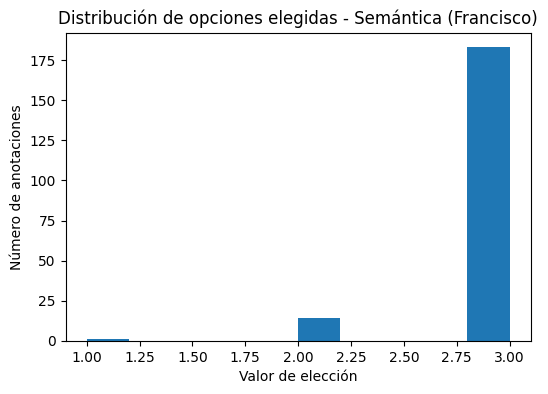

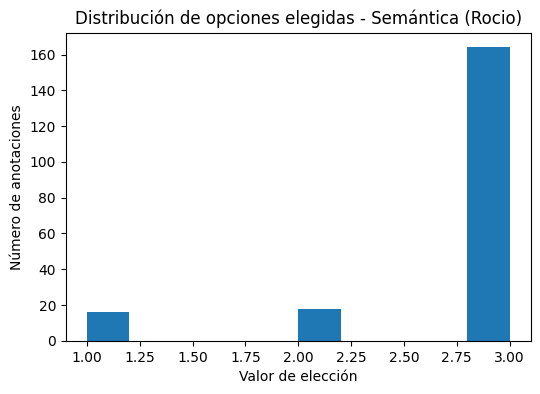

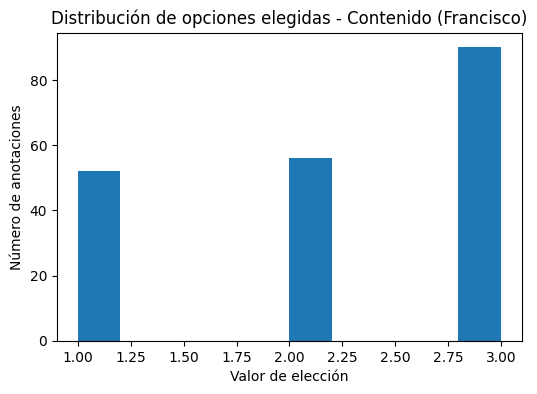

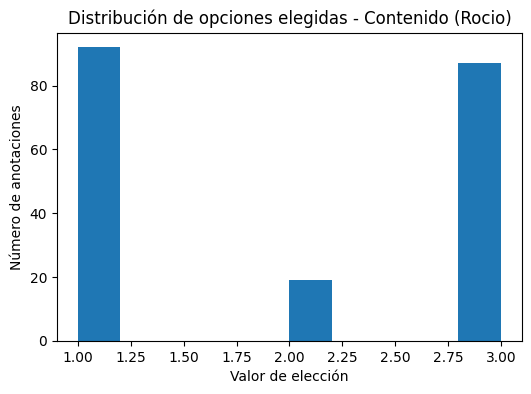

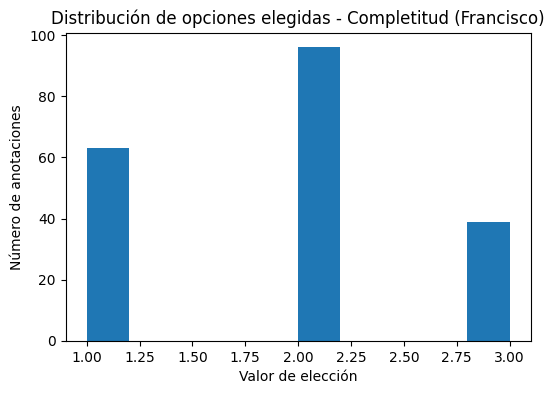

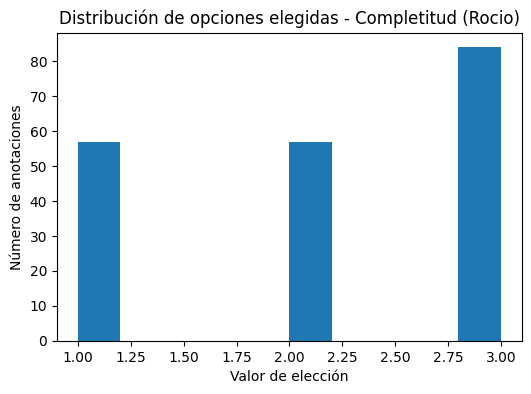

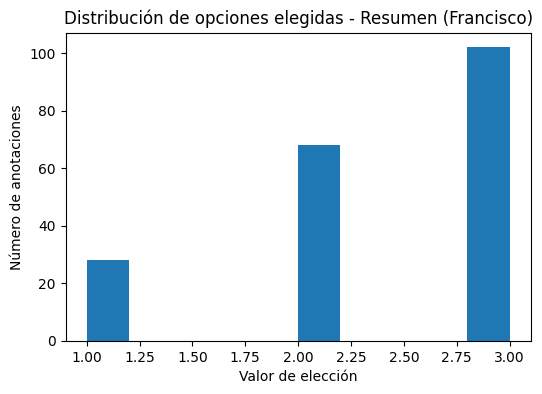

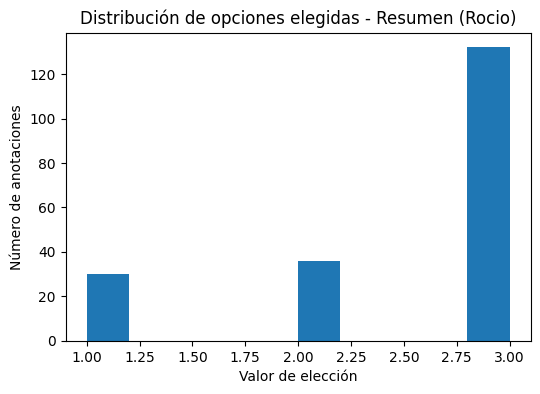

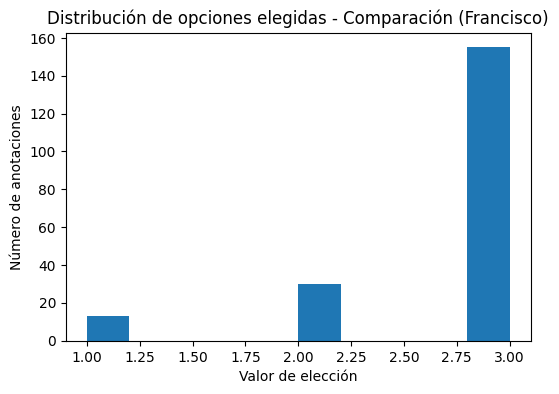

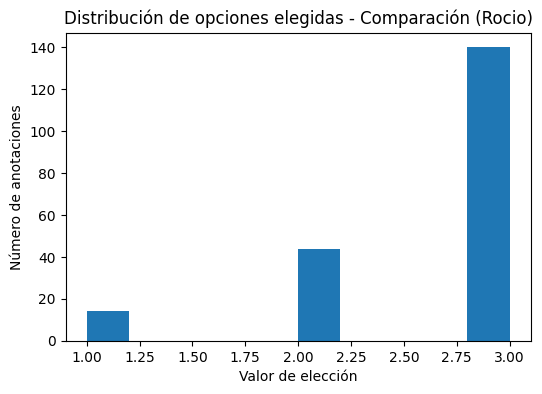

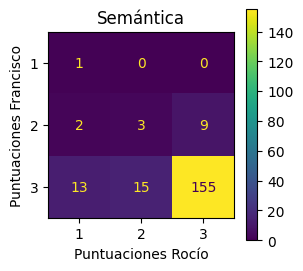

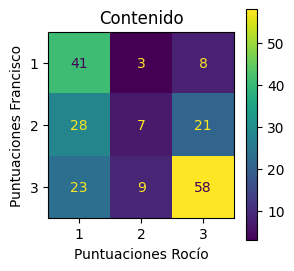

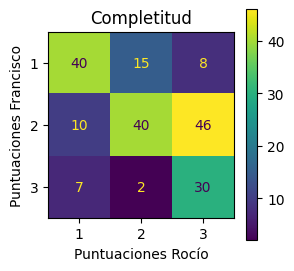

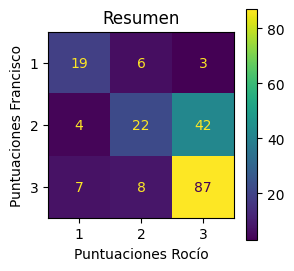

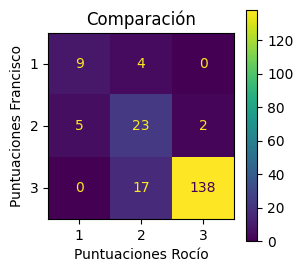

In [22]:
import json
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as mlp
from filterTools import csvFilter

## Recuperamos las anotaciones
with open('data/KWExtract-Evaluation.json', 'r', encoding='utf-8') as f1:
    all_evals = json.load(f1)
    print('Evaluaciones cargadas')

    ## Guardamos por aparte las evaluaciones que existen en ambos grupos (1 y 2)
    double_evals = {}
    for eval1 in all_evals["1"]:
        eval2 = next((e for e in all_evals["2"] if e['conv_id'] == eval1['conv_id']), False)
        if eval2:
            double_evals[eval1['conv_id']] = (
                (eval1['semantic'], eval1['content'], eval1['completeness'], eval1['summary'], eval1['comparison']),
                (eval2['semantic'], eval2['content'], eval2['completeness'], eval2['summary'], eval2['comparison'])
            )
    print(f'Evaluaciones con coincidencia: {len(double_evals)}')
    
    semantic_evals = ([e[0][0] for e in double_evals.values()], [e[1][0] for e in double_evals.values()])
    content_evals = ([e[0][1] for e in double_evals.values()], [e[1][1] for e in double_evals.values()])
    completeness_evals = ([e[0][2] for e in double_evals.values()], [e[1][2] for e in double_evals.values()])
    summary_evals = ([e[0][3] for e in double_evals.values()], [e[1][3] for e in double_evals.values()])
    comparison_evals = ([e[0][4] for e in double_evals.values()], [e[1][4] for e in double_evals.values()])

    print('\nMÉTRICAS')
    print('-REDACCIÓN')
    print(f'--Proporción de coincidencias: {np.average([e1 == semantic_evals[1][i] for i, e1 in enumerate(semantic_evals[0])])}')
    print(f'--Acuerdo Kappa de Cohen: {cohen_kappa_score(semantic_evals[0], semantic_evals[1], labels=[1, 2, 3])}')
    print('-CONTENIDO')
    print(f'--Proporción de coincidencias: {np.average([e1 == content_evals[1][i] for i, e1 in enumerate(content_evals[0])])}')
    print(f'--Acuerdo Kappa de Cohen: {cohen_kappa_score(content_evals[0], content_evals[1], labels=[1, 2, 3])}')
    print('-COMPLETITUD')
    print(f'--Proporción de coincidencias: {np.average([e1 == completeness_evals[1][i] for i, e1 in enumerate(completeness_evals[0])])}')
    print(f'--Acuerdo Kappa de Cohen: {cohen_kappa_score(completeness_evals[0], completeness_evals[1], labels=[1, 2, 3])}')
    print('-RESUMEN')
    print(f'--Proporción de coincidencias: {np.average([e1 == summary_evals[1][i] for i, e1 in enumerate(summary_evals[0])])}')
    print(f'--Acuerdo Kappa de Cohen: {cohen_kappa_score(summary_evals[0], summary_evals[1], labels=[1, 2, 3])}')
    print('-COMPARATIVA')
    print(f'--Proporción de coincidencias: {np.average([e1 == comparison_evals[1][i] for i, e1 in enumerate(comparison_evals[0])])}')
    print(f'--Acuerdo Kappa de Cohen: {cohen_kappa_score(comparison_evals[0], comparison_evals[1], labels=[1, 2, 3])}')

    semantic_diffs = {id: (ev[0][0], ev[1][0]) for id, ev in double_evals.items() if ev[0][0] != ev[1][0]}
    content_diffs = {id: (ev[0][1], ev[1][1]) for id, ev in double_evals.items() if ev[0][1] != ev[1][1]}
    completeness_diffs = {id: (ev[0][2], ev[1][2]) for id, ev in double_evals.items() if ev[0][2] != ev[1][2]}
    summary_diffs = {id: (ev[0][3], ev[1][3]) for id, ev in double_evals.items() if ev[0][3] != ev[1][3]}
    comparison_diffs = {id: (ev[0][4], ev[1][4]) for id, ev in double_evals.items() if ev[0][4] != ev[1][4]}

    print('\nDIFERENCIAS')
    print('-REDACCIÓN')
    for id, (ev1, ev2) in list(semantic_diffs.items())[:10]:
        print(f'--Disc {id}: {ev1} - {ev2}')
    print('-CONTENIDO')
    for id, (ev1, ev2) in list(content_diffs.items())[:10]:
        print(f'--Disc {id}: {ev1} - {ev2}')
    print('-COMPLETITUD')
    for id, (ev1, ev2) in list(completeness_diffs.items())[:10]:
        print(f'--Disc {id}: {ev1} - {ev2}')
    print('-RESUMEN')
    for id, (ev1, ev2) in list(summary_diffs.items())[:10]:
        print(f'--Disc {id}: {ev1} - {ev2}')
    print('-COMPARATIVA')
    for id, (ev1, ev2) in list(comparison_diffs.items())[:10]:
        print(f'--Disc {id}: {ev1} - {ev2}')


    mlp.rcParams['figure.figsize'] = [6, 4]

    mlp.title("Distribución de opciones elegidas - Semántica (Francisco)")
    mlp.xlabel('Valor de elección')
    mlp.ylabel('Número de anotaciones')
    mlp.hist(semantic_evals[0])
    mlp.show()
    mlp.title("Distribución de opciones elegidas - Semántica (Rocio)")
    mlp.xlabel('Valor de elección')
    mlp.ylabel('Número de anotaciones')
    mlp.hist(semantic_evals[1])
    mlp.show()
    mlp.title("Distribución de opciones elegidas - Contenido (Francisco)")
    mlp.xlabel('Valor de elección')
    mlp.ylabel('Número de anotaciones')
    mlp.hist(content_evals[0])
    mlp.show()
    mlp.title("Distribución de opciones elegidas - Contenido (Rocio)")
    mlp.xlabel('Valor de elección')
    mlp.ylabel('Número de anotaciones')
    mlp.hist(content_evals[1])
    mlp.show()
    mlp.title("Distribución de opciones elegidas - Completitud (Francisco)")
    mlp.xlabel('Valor de elección')
    mlp.ylabel('Número de anotaciones')
    mlp.hist(completeness_evals[0])
    mlp.show()
    mlp.title("Distribución de opciones elegidas - Completitud (Rocio)")
    mlp.xlabel('Valor de elección')
    mlp.ylabel('Número de anotaciones')
    mlp.hist(completeness_evals[1])
    mlp.show()
    mlp.title("Distribución de opciones elegidas - Resumen (Francisco)")
    mlp.xlabel('Valor de elección')
    mlp.ylabel('Número de anotaciones')
    mlp.hist(summary_evals[0])
    mlp.show()
    mlp.title("Distribución de opciones elegidas - Resumen (Rocio)")
    mlp.xlabel('Valor de elección')
    mlp.ylabel('Número de anotaciones')
    mlp.hist(summary_evals[1])
    mlp.show()
    mlp.title("Distribución de opciones elegidas - Comparación (Francisco)")
    mlp.xlabel('Valor de elección')
    mlp.ylabel('Número de anotaciones')
    mlp.hist(comparison_evals[0])
    mlp.show()
    mlp.title("Distribución de opciones elegidas - Comparación (Rocio)")
    mlp.xlabel('Valor de elección')
    mlp.ylabel('Número de anotaciones')
    mlp.hist(comparison_evals[1])
    mlp.show()

    csvFilter('data/KeywordExtract/TextRank/tutors/keywords-tutors-summ-divided.csv', lambda disc: int(disc['ID conversación']) in semantic_diffs.keys(), write=True, tag='-semantic_diffs')
    csvFilter('data/KeywordExtract/TextRank/tutors/keywords-tutors-summ-divided.csv', lambda disc: int(disc['ID conversación']) in content_diffs.keys(), write=True, tag='-content_diffs')
    csvFilter('data/KeywordExtract/TextRank/tutors/keywords-tutors-summ-divided.csv', lambda disc: int(disc['ID conversación']) in completeness_diffs.keys(), write=True, tag='-completeness_diffs')
    csvFilter('data/KeywordExtract/TextRank/tutors/keywords-tutors-summ-divided.csv', lambda disc: int(disc['ID conversación']) in summary_diffs.keys(), write=True, tag='-summary_diffs')
    csvFilter('data/KeywordExtract/TextRank/tutors/keywords-tutors-summ-divided.csv', lambda disc: int(disc['ID conversación']) in comparison_diffs.keys(), write=True, tag='-comparison_diffs')

    cmatrix = confusion_matrix(semantic_evals[0], semantic_evals[1], labels=[1, 2, 3])
    fig = ConfusionMatrixDisplay(cmatrix)
    fig.plot()
    fig.figure_.set_figwidth(3)
    fig.figure_.set_figheight(3)
    fig.ax_.set_ylabel("Puntuaciones Francisco")
    fig.ax_.set_xlabel("Puntuaciones Rocío")
    fig.ax_.set_title("Semántica")
    fig.ax_.xaxis.set_ticklabels(['1', '2', '3'])
    fig.ax_.yaxis.set_ticklabels(['1', '2', '3'])

    cmatrix = confusion_matrix(content_evals[0], content_evals[1], labels=[1, 2, 3])
    fig = ConfusionMatrixDisplay(cmatrix)
    fig.plot()
    fig.figure_.set_figwidth(3)
    fig.figure_.set_figheight(3)
    fig.ax_.set_ylabel("Puntuaciones Francisco")
    fig.ax_.set_xlabel("Puntuaciones Rocío")
    fig.ax_.set_title("Contenido")
    fig.ax_.xaxis.set_ticklabels(['1', '2', '3'])
    fig.ax_.yaxis.set_ticklabels(['1', '2', '3'])

    cmatrix = confusion_matrix(completeness_evals[0], completeness_evals[1], labels=[1, 2, 3])
    fig = ConfusionMatrixDisplay(cmatrix)
    fig.plot()
    fig.figure_.set_figwidth(3)
    fig.figure_.set_figheight(3)
    fig.ax_.set_ylabel("Puntuaciones Francisco")
    fig.ax_.set_xlabel("Puntuaciones Rocío")
    fig.ax_.set_title("Completitud")
    fig.ax_.xaxis.set_ticklabels(['1', '2', '3'])
    fig.ax_.yaxis.set_ticklabels(['1', '2', '3'])

    cmatrix = confusion_matrix(summary_evals[0], summary_evals[1], labels=[1, 2, 3])
    fig = ConfusionMatrixDisplay(cmatrix)
    fig.plot()
    fig.figure_.set_figwidth(3)
    fig.figure_.set_figheight(3)
    fig.ax_.set_ylabel("Puntuaciones Francisco")
    fig.ax_.set_xlabel("Puntuaciones Rocío")
    fig.ax_.set_title("Resumen")
    fig.ax_.xaxis.set_ticklabels(['1', '2', '3'])
    fig.ax_.yaxis.set_ticklabels(['1', '2', '3'])

    cmatrix = confusion_matrix(comparison_evals[0], comparison_evals[1], labels=[1, 2, 3])
    fig = ConfusionMatrixDisplay(cmatrix)
    fig.plot()
    fig.figure_.set_figwidth(3)
    fig.figure_.set_figheight(3)
    fig.ax_.set_ylabel("Puntuaciones Francisco")
    fig.ax_.set_xlabel("Puntuaciones Rocío")
    fig.ax_.set_title("Comparación")
    fig.ax_.xaxis.set_ticklabels(['1', '2', '3'])
    fig.ax_.yaxis.set_ticklabels(['1', '2', '3'])


In [2]:
import json

## Recuperamos las anotaciones
with open('data/KWExtract-Evaluation.json', 'r', encoding='utf-8') as f1:
    all_evals = json.load(f1)
    print('Evaluaciones cargadas')

    mumuki_evals = all_evals["2"]
    total_evals = len(mumuki_evals)
    print(f'Total evaluaciones: {total_evals}')
    print(f'Promedio redacción: {sum(e["semantic"] for e in mumuki_evals)/total_evals}')
    print(f'Promedio contenido: {sum(e["content"] for e in mumuki_evals)/total_evals}')
    print(f'Promedio completitud: {sum(e["completeness"] for e in mumuki_evals)/total_evals}')
    print(f'Promedio resumen: {sum(e["summary"] for e in mumuki_evals)/total_evals}')
    print(f'Promedio comparativa: {sum(e["comparison"] for e in mumuki_evals)/total_evals}')

Evaluaciones cargadas
Total evaluaciones: 998
Promedio redacción: 2.8016032064128256
Promedio contenido: 2.0831663326653307
Promedio completitud: 2.2685370741482966
Promedio resumen: 2.495991983967936
Promedio comparativa: 2.561122244488978
